The goal of the assignment is to conduct a trend analysis of some variable of interest. Graph it and try different functional forms. Look for subgroup variation across time, too. The dataset suggested was the General Social Survey (GSS)

# Imports

In [ ]:
import pandas as pd
import requests
import zipfile
import io
from tqdm.notebook import tqdm
from __future__ import division
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import os
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis
import seaborn as sns

In [ ]:
# Step 1: Download the ZIP file with progress bar
url = 'https://gss.norc.org/content/dam/gss/get-the-data/documents/stata/GSS_stata.zip'

# Make a streaming request to get the content in chunks
response = requests.get(url, stream=True)
total_size = int(response.headers.get('content-length', 0))  # Get the total file size
block_size = 1024  # 1 Kilobyte

# Progress bar for downloading
tqdm_bar = tqdm(total=total_size, unit='iB', unit_scale=True)
content = io.BytesIO()

# Download the file in chunks with progress bar
for data in response.iter_content(block_size):
    tqdm_bar.update(len(data))
    content.write(data)

tqdm_bar.close()

# Check if the download is successful
if total_size != 0 and tqdm_bar.n != total_size:
    print("Error in downloading the file.")
else:
    print("Download completed!")

# Step 2: Extract the ZIP file in memory and display progress
with zipfile.ZipFile(content) as z:
    # List all files in the zip
    file_list = z.namelist()

    # Filter for the .dta file (assuming there is only one)
    stata_files = [file for file in file_list if file.endswith('.dta')]

    # If there is a Stata file, proceed to extract and read it
    if stata_files:
        stata_file = stata_files[0]  # Take the first .dta file
        with z.open(stata_file) as stata_file_stream:
            # Step 3a: Load only the selected columns into a pandas DataFrame with numeric labels
            columns_to_load = ['id', 'degree', 'natmass', 'year', 'carprivt', 'realinc', 'partyid', 'xnorcsiz']
            print("Loading selected columns from Stata file with numeric labels...")
            df_numeric = pd.read_stata(stata_file_stream, columns=columns_to_load, convert_categoricals=False)
            print("Data with numeric labels loaded successfully!")

        # Reload the dataset to get categorical (string) labels
        with z.open(stata_file) as stata_file_stream:
            print("Loading selected columns from Stata file with string (categorical) labels...")
            df_categorical = pd.read_stata(stata_file_stream, columns=columns_to_load)
            print("Data with categorical labels loaded successfully!")

            # Step 3b: Rename the categorical columns by prefixing with 'z' (no period)
            df_categorical = df_categorical.rename(columns={col: f'z{col}' for col in df_categorical.columns})

# Step 4: Concatenate the numeric and categorical DataFrames side by side
df = pd.concat([df_numeric, df_categorical], axis=1)

# Step 5: Display the first few rows of the final DataFrame
df.head()

  0%|          | 0.00/45.7M [00:00<?, ?iB/s]

Download completed!
Loading selected columns from Stata file with numeric labels...
Data with numeric labels loaded successfully!
Loading selected columns from Stata file with string (categorical) labels...


/tmp/ipython-input-554732915.py:47: UnicodeWarning: 
One or more strings in the dta file could not be decoded using utf-8, and
so the fallback encoding of latin-1 is being used.  This can happen when a file
has been incorrectly encoded by Stata or some other software. You should verify
the string values returned are correct.
  df_categorical = pd.read_stata(stata_file_stream, columns=columns_to_load)


Data with categorical labels loaded successfully!


,id,degree,natmass,year,carprivt,realinc,partyid,xnorcsiz,zid,zdegree,znatmass,zyear,zcarprivt,zrealinc,zpartyid,zxnorcsiz
0,1,3.0,NaN,1972,NaN,18951.0,2.0,3,1,bachelor's,NaN,1972,NaN,18951.0,"independent, close to democrat",a suburb of a large central city
1,2,0.0,NaN,1972,NaN,24366.0,1.0,3,2,less than high school,NaN,1972,NaN,24366.0,not very strong democrat,a suburb of a large central city
2,3,1.0,NaN,1972,NaN,24366.0,3.0,3,3,high school,NaN,1972,NaN,24366.0,"independent (neither, no response)",a suburb of a large central city
3,4,3.0,NaN,1972,NaN,30458.0,1.0,3,4,bachelor's,NaN,1972,NaN,30458.0,not very strong democrat,a suburb of a large central city
4,5,1.0,NaN,1972,NaN,50763.0,0.0,3,5,high school,NaN,1972,NaN,50763.0,strong democrat,a suburb of a large central city


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 75699 entries, 0 to 75698
Data columns (total 16 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   id         75699 non-null  int16   
 1   degree     75500 non-null  float64 
 2   natmass    50301 non-null  float64 
 3   year       75699 non-null  int16   
 4   carprivt   735 non-null    float64 
 5   realinc    64912 non-null  float64 
 6   partyid    75173 non-null  float64 
 7   xnorcsiz   75699 non-null  int8    
 8   zid        75699 non-null  int16   
 9   zdegree    75500 non-null  category
 10  znatmass   50301 non-null  category
 11  zyear      75699 non-null  category
 12  zcarprivt  735 non-null    category
 13  zrealinc   64912 non-null  category
 14  zpartyid   75173 non-null  category
 15  zxnorcsiz  75699 non-null  category
dtypes: category(7), float64(5), int16(3), int8(1)
memory usage: 4.0 MB


# Regression Analysis

['about right', 'too little', 'too much']
Categories (3, object): ['too little' < 'about right' < 'too much']


/tmp/ipython-input-3793312844.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['znatmass_binary'] = np.select(conditions, choices, default=np.nan)


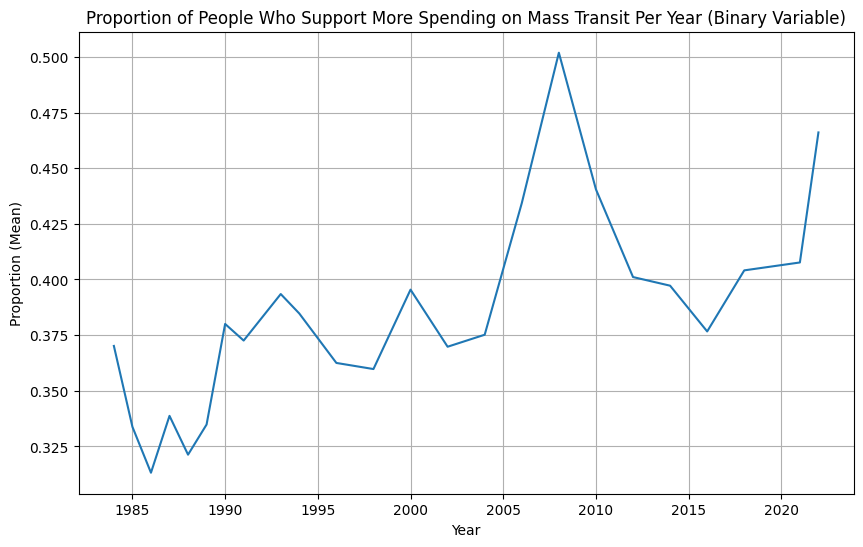

In [ ]:
# I wanted to investigate if car ownership affected national support for mass
# transit, but there are only 735 non-null responses to the question "have you
# purchased a car in the last 5 years"? Will shift to investigate how geographic
# region (urban, suburban, rural) and education affect support for mass transit.
# I'd also be curious to investigate political party (that relationship may be
# too obvious) and real income but may be overscoping this project.

# Step 1: Drop observations with NA values in any variable listed
df_clean = df.dropna(subset=['year', 'natmass', 'degree', 'xnorcsiz'])

# Step 2: Define conditions and choices for the variable
print(df_clean['znatmass'].unique()) #all of the unique responses to the question
conditions = [
    (df_clean['znatmass'] == 'too little'), # supports more spending
    (df_clean['znatmass'] != 'too little')  # either against or ambivalent about reducing spending
]

choices = [1, 0]  # 1 for "we spent too little", 0 for all other responses

# Step 3: Use np.select to create a new binary variable based on the conditions
df_clean['znatmass_binary'] = np.select(conditions, choices, default=np.nan)

# Step 4: Calculate the mean of the new binary variable by year
mean_natmass_per_year = df_clean.groupby('year')['znatmass_binary'].mean().reset_index()

# Step 5: Plot the mean of the binary  variable by year
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='znatmass_binary', data=mean_natmass_per_year)
plt.title('Proportion of People Who Support More Spending on Mass Transit Per Year (Binary Variable)')
plt.xlabel('Year')
plt.ylabel('Proportion (Mean)')
plt.grid(True)
plt.show()

This shows more people are interested in supporting mass transit now than 40 years ago (going from ~<40% of the population to ~50%). This is not what I expected - I thought support for public transit would decrease given the fact that we are not building a lot of new transit in the country.

In [ ]:
df_clean.groupby('year')['znatmass'].apply(lambda x: (x == 'too little').mean() * 100).reset_index()

,year,znatmass
0,1984,37.015945
1,1985,33.381924
2,1986,31.320755
3,1987,33.875000
4,1988,32.131661
5,1989,33.485540
6,1990,38.003356
7,1991,37.257824
8,1993,39.346591
9,1994,38.472998


## Linear Model

In [ ]:
# Step 1: Run the regression using the formula interface
model0 = smf.ols(formula='znatmass_binary ~ year', data=df_clean)

# Step 2: Fit the model
results0 = model0.fit()

# Step 3: Output the summary of the regression
print(results0.summary())

                            OLS Regression Results                            
Dep. Variable:        znatmass_binary   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     171.9
Date:                Tue, 07 Oct 2025   Prob (F-statistic):           3.33e-39
Time:                        03:34:16   Log-Likelihood:                -35144.
No. Observations:               50200   AIC:                         7.029e+04
Df Residuals:                   50198   BIC:                         7.031e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.4148      0.367    -12.042      0.0

If we simply include a linear time trend, we see that it is quite statistically significant. The coefficient shows that for each year that goes by, the percentage of people who say they support mass transit goes up by 0.24 percentage points per year. The Adj. R-squared is quite small, with time explaining only 0.3% of all variation in support for mass transit.

In [ ]:
# In which years were there unique or significant effects?
model1 = smf.ols(formula='znatmass_binary ~ C(year)', data=df_clean)
results1 = model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:        znatmass_binary   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     16.38
Date:                Tue, 07 Oct 2025   Prob (F-statistic):           1.91e-65
Time:                        03:34:17   Log-Likelihood:                -35042.
No. Observations:               50200   AIC:                         7.013e+04
Df Residuals:                   50176   BIC:                         7.034e+04
Df Model:                          23                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.3702      0.016     

If we include year dummies in the model, we see that most of the years, especially after 2006, are statistically different from the first year of data in 1984.  In fact, in 2008, 13 percentage points more people said they supported mass transit, compared to in 1984 -- and this difference appears statistically significant. The Adj. R-squared indicates that this model captures 0.7% of variation in support of mass transit.

## Quadratic Model

In [ ]:
# Try a quadratic relationship
model2 = smf.ols(formula='znatmass_binary ~ year + year^2', data=df_clean)
results2 = model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:        znatmass_binary   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     88.05
Date:                Tue, 07 Oct 2025   Prob (F-statistic):           6.74e-39
Time:                        03:34:17   Log-Likelihood:                -35141.
No. Observations:               50200   AIC:                         7.029e+04
Df Residuals:                   50197   BIC:                         7.032e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -4.4043      0.367    -12.012      0.0

The quadratic model does not improve on the simple linear model significantly. Although the Year^2 variable is statistically significant, the adj. R-squared is the same as the linear model, showing that the quadratic model does not capture the variability any better than the linear model.  

## Subgroup Variation

I then turned to look for subgroup variation across time, too.  I looked at whether there are differences in the trends for people who live in suburbs vs urban areas. I'm not sure how this will go - I imagine most urban participants would want more transit but some may actually prefer more space for cars. I can also imagine suburban participants want both as well.

/tmp/ipython-input-2448555023.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['xnorcsiz'] = pd.to_numeric(df_clean['xnorcsiz'], errors='coerce')
/tmp/ipython-input-2448555023.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_clean['geo'] = np.select(geo_conditions, geo_choices, default=None)


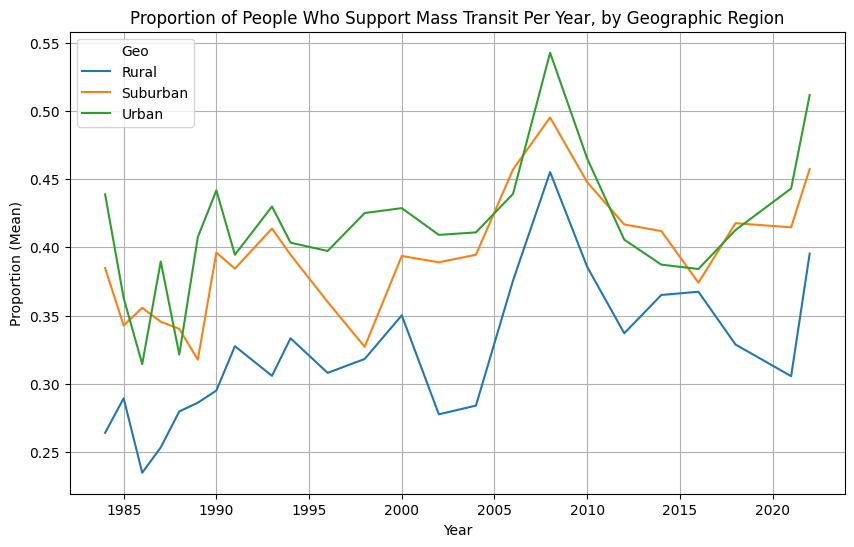

In [ ]:
# Step 1: Define conditions and choices for the  variable
# https://gssdataexplorer.norc.org/variables/120/vshow

df_clean['xnorcsiz'] = pd.to_numeric(df_clean['xnorcsiz'], errors='coerce')

geo_conditions = [
    (df_clean['xnorcsiz'] < 3),
    ((df_clean['xnorcsiz'] > 2) & (df_clean['xnorcsiz'] < 7)),
    (df_clean['xnorcsiz'] > 6)
]

geo_choices = ['Urban', 'Suburban', 'Rural']

# Step 2: Use np.select to create a new categorical variable based on the conditions
df_clean['geo'] = np.select(geo_conditions, geo_choices, default=None)

# Step 3: Calculate the mean of the binary variable by year and geo group
mean_natmass_per_year_geo = df_clean.groupby(['year', 'geo'])['znatmass_binary'].mean().reset_index()

# Step4: Plot the mean of the binary variable by year, split by geo
plt.figure(figsize=(10, 6))
sns.lineplot(x='year', y='znatmass_binary', hue='geo', data=mean_natmass_per_year_geo)
plt.title('Proportion of People Who Support Mass Transit Per Year, by Geographic Region')
plt.xlabel('Year')
plt.ylabel('Proportion (Mean)')
plt.legend(title='Geo')  # Automatically create the legend based on hue
plt.grid(True)
plt.show()

In general, across all three subgroups, support for mass transit increases over the 40 years of the survey. But, there is a consistent gap of around 10% between the urban and rural groups. The peak around 2008 - is that caused by the Financial Recession? The peak after 2020 - is that related to COVID?

In [ ]:
model3 = smf.ols(formula='znatmass_binary ~ year + geo', data=df_clean)
results3 = model3.fit()
print(results3.summary())

                            OLS Regression Results                            
Dep. Variable:        znatmass_binary   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     131.6
Date:                Tue, 07 Oct 2025   Prob (F-statistic):           6.45e-85
Time:                        03:34:17   Log-Likelihood:                -35033.
No. Observations:               50200   AIC:                         7.007e+04
Df Residuals:                   50196   BIC:                         7.011e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept          -3.9534      0.368    -

Across all groups, there is a statistically significant relationship between that group and support for mass transit. Urban participants support mass transit by ~9% compared to rural populations, net of year. The Adj. R-squared is improved over the original simple linear model.

In [ ]:
# Do the urban/rural gaps widen?
model4 = smf.ols(formula='znatmass_binary ~ year*geo', data=df_clean)
results4 = model4.fit()
print(results4.summary())

                            OLS Regression Results                            
Dep. Variable:        znatmass_binary   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     79.35
Date:                Tue, 07 Oct 2025   Prob (F-statistic):           3.22e-83
Time:                        03:34:17   Log-Likelihood:                -35032.
No. Observations:               50200   AIC:                         7.008e+04
Df Residuals:                   50194   BIC:                         7.013e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -4.8372 

When we interact year with geo, we see that the interaction is not statistically significant, suggesting that the two groups are increasing their support for mass transit at the same rate (as corroborated by the earlier chart). There is no significant evidence that the trends in support for mass transit differ across urban, suburban, and rural America. This could be a good starting point for a difference-in-differences model.

What if we control for education? For example, after we account for education, does living in an urban area still make someone more likely to support mass transit? In particular, urban areas will (or should) have diversity in education levels.

In [ ]:
model5 = smf.ols(formula='znatmass_binary ~ geo*year + C(degree)', data=df_clean)
results5 = model5.fit()
print(results5.summary())

                            OLS Regression Results                            
Dep. Variable:        znatmass_binary   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.028
Method:                 Least Squares   F-statistic:                     160.9
Date:                Tue, 07 Oct 2025   Prob (F-statistic):          8.32e-302
Time:                        03:34:18   Log-Likelihood:                -34515.
No. Observations:               50200   AIC:                         6.905e+04
Df Residuals:                   50190   BIC:                         6.914e+04
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept               -3.7119 

The conclusion that there is no significant evidence that the trends in support for mass transit differ across urban, suburban, and rural areas remains true.

This models finds that as time goes on and as education level increases, support for mass transit increase, and those relationships are statistically significant. Each additional year increases the probability of supporting more transit spending by 0.2 percentage points (pp). Relative to less than high school education:
*   High school grads (C(degree)=1): +1.4pp
*   Some college (C(degree)=2): +4.6pp
*   College degree (C(degree)=3): +12.8pp
*   Graduate degree (C(degree)=4): +22.2pp

The Adj. R-squared increased to 2.8%, suggesting this model better captures the variability in mass transit opinion.